*************************************************************

Loading Abaqus-mesh from D:\NDCIS\framework\data\ansys_simple_blade_disc_files\simple_blade_disc.inp
Can not read the given string list
WARNING 3D case were selected
Mesh D:\NDCIS\framework\data\ansys_simple_blade_disc_files\simple_blade_disc.inp successfully imported. 
Assign a material to a physical group.
*************************************************************


<IPython.core.display.Javascript object>


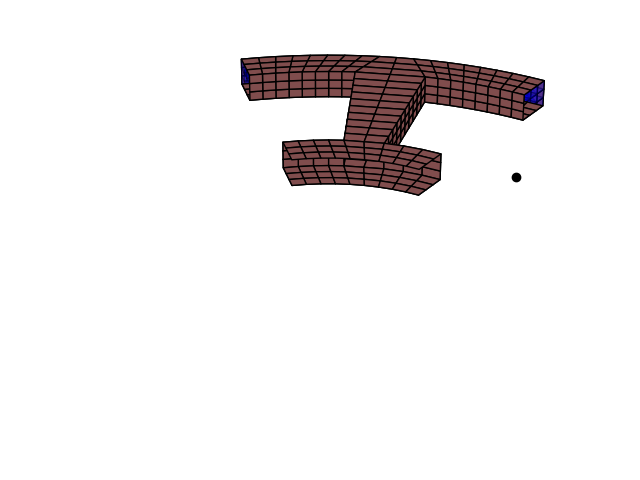

(-21.047588429999998,
 21.047588429999998,
 -21.047588429999998,
 21.047588429999998)

In [3]:
# importing lib and setting a list of meshes to be tested
import sys 
import amfe
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import linalg as splinalg
import copy
%matplotlib notebook


# making the path relative to the project
local_folder = os.getcwd()[:]
os.chdir('..')
project_folder = os.getcwd()[:]
os.chdir(local_folder)
sys.path.append(r'project_folder')

mesh_inp = os.path.join(project_folder,r'data\ansys_simple_blade_disc_files\simple_blade_disc.inp')


m = amfe.Mesh()
m.import_inp(mesh_inp,1.0)

ax = amfe.plot3Dmesh(m, ax=None, boundaries=True, alpha=0.2, color='blue', scale = 1000, plot_nodes=False)
ax.view_init(-90, 0)
#ax.set_aspect('equal', adjustable='box')
xlim = ax.get_xlim()
ax.set_ylim(xlim)
ax.set_zlim(xlim)
plt.axis('off')

In [2]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain('SOLID_1_1_SOLID_ELSET',my_material)

K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()

dirsub = m.get_submesh('phys_group', 'DIRICHLET_ELSET')
cyclic_low = m.get_submesh('phys_group', 'LOW_ELSET')
cyclic_high = m.get_submesh('phys_group', 'HIGH_ELSET')
cyclic_top_low = m.get_submesh('phys_group', 'TOP_LOW_ELSET')
cyclic_top_high = m.get_submesh('phys_group', 'TOP_HIGH_ELSET')

id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = amfe.get_dirichlet_dofs(dirsub, direction ='xyz', id_matrix=id_matrix)
low_dofs = amfe.get_dirichlet_dofs(cyclic_low, direction ='xyz', id_matrix=id_matrix)
high_dofs = amfe.get_dirichlet_dofs(cyclic_high, direction ='xyz', id_matrix=id_matrix)
top_low_dofs = amfe.get_dirichlet_dofs(cyclic_top_low, direction ='xyz', id_matrix=id_matrix)
top_high_dofs = amfe.get_dirichlet_dofs(cyclic_top_high, direction ='xyz', id_matrix=id_matrix)


# concatenating cyclic dofs
all_low_dofs =[]
all_low_dofs.extend(low_dofs)
all_low_dofs.extend(top_low_dofs)
all_high_dofs = []
all_high_dofs.extend(high_dofs)
all_high_dofs.extend(top_high_dofs)


# remove Dirichle dofs at cyclic dofs 
dir_dofs = list(set(dir_dofs).difference(all_low_dofs))
dir_dofs = list(set(dir_dofs).difference(all_high_dofs))

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 303 elements and 1716 dofs.
Time taken for preallocation: 0.02 seconds.
